# Yolo 8 food detection

In [1]:
# !pip install ultralytics

In [2]:
!pip install pyYAML

In [3]:
from ultralytics import YOLO
import numpy as np
import os
from PIL import Image
import pandas as pd
import torch as torch

In [4]:
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(cuda_id)
    device = "cuda:0"
else:
    device = "cpu"

In [5]:
# Load a pretrained YOLO model
model = YOLO("yolov8n.pt").to(device)

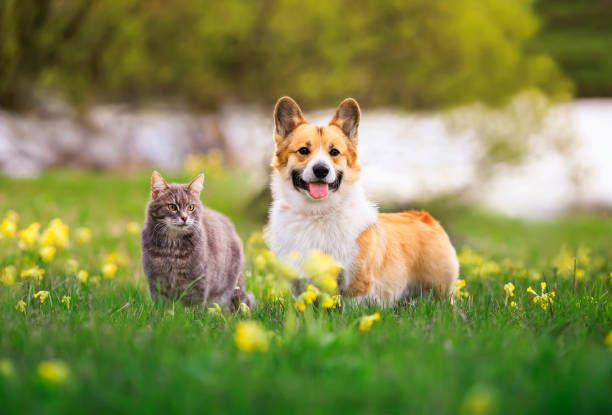

In [6]:
cat_dog = Image.open("cat_dog.jpg")
cat_dog = np.asarray(cat_dog)
Image.fromarray(cat_dog)

In [7]:
cat_dog.shape

(415, 612, 3)

In [8]:
result = model.predict(cat_dog)


0: 448x640 1 dog, 1 sheep, 1 bear, 72.3ms
Speed: 3.0ms preprocess, 72.3ms inference, 7.0ms postprocess per image at shape (1, 3, 448, 640)


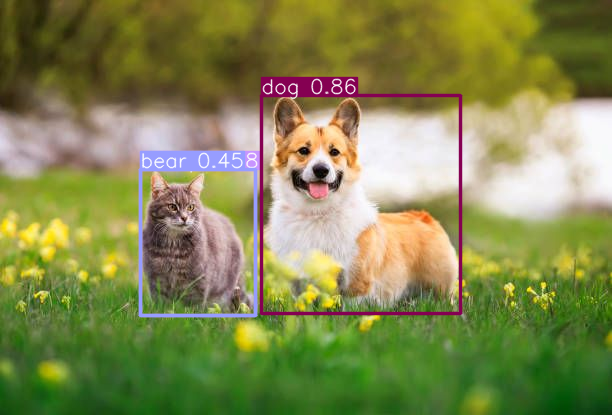

In [9]:
Image.fromarray(result[0].plot())

In [10]:
names = pd.read_csv("oidv7-class-descriptions-boxable.csv")
translate_dict = {}
for row in names.iterrows():
    translate_dict[row[1]["LabelName"]] = row[1]["DisplayName"]
    
translate_dict["/m/02wbm"]

'Food'

In [11]:
if not os.path.exists("datasets/train_images"): os.mkdir("datasets/train_images")
if not os.path.exists("datasets/valid_images"): os.mkdir("datasets/valid_images")
if not os.path.exists("datasets/test_images"): os.mkdir("datasets/test_images")

In [12]:
annotations_train = pd.read_csv("oidv6-train-annotations-bbox.csv")
annotations_train["DisplayName"] = annotations_train["LabelName"].map(translate_dict)
annotations_train = annotations_train[annotations_train["DisplayName"] == "Food"]

food_train = annotations_train["ImageID"]
food_train = food_train.drop_duplicates()[:4000]

train_data = pd.merge(food_train,annotations_train, on="ImageID", how='inner')[["ImageID","XMin","XMax","YMin","YMax"]]

for image in food_train:
    name = "datasets/train_images/"+image+".txt"
    if os.path.exists(name): os.remove(name)
    with open(name, "w", encoding="utf-8") as file:
        for row in train_data.loc[train_data["ImageID"]==image].iterrows():
            xmin,xmax,ymin,ymax = row[1]["XMin"],row[1]["XMax"],row[1]["YMin"],row[1]["YMax"]
            xcenter,ycenter = (xmin+xmax)/2,(ymin+ymax)/2
            width,height = xmax-xmin,ymax-ymin
            file.write("0 " + str(xcenter) + " " + str(ycenter) + " " + str(width) + " " + str(height) + "\n")

In [13]:
annotations_valid = pd.read_csv("validation-annotations-bbox.csv")
annotations_valid["DisplayName"] = annotations_valid["LabelName"].map(translate_dict)
annotations_valid = annotations_valid[annotations_valid["DisplayName"] == "Food"]

food_valid = annotations_valid["ImageID"]
food_valid = food_valid.drop_duplicates()[:1000]

valid_data = pd.merge(food_valid,annotations_valid, on="ImageID", how='inner')[["ImageID","XMin","XMax","YMin","YMax"]]

for image in food_valid:
    name = "datasets/valid_images/"+image+".txt"
    if os.path.exists(name): os.remove(name)
    with open(name, "w", encoding="utf-8") as file:
        for row in valid_data.loc[valid_data["ImageID"]==image].iterrows():
            xmin,xmax,ymin,ymax = row[1]["XMin"],row[1]["XMax"],row[1]["YMin"],row[1]["YMax"]
            xcenter,ycenter = (xmin+xmax)/2,(ymin+ymax)/2
            width,height = xmax-xmin,ymax-ymin
            file.write("0 " + str(xcenter) + " " + str(ycenter) + " " + str(width) + " " + str(height) + "\n")

In [14]:
annotations_test = pd.read_csv("test-annotations-bbox.csv")
annotations_test["DisplayName"] = annotations_test["LabelName"].map(translate_dict)
annotations_test=annotations_test[annotations_test["DisplayName"] == "Food"]

food_test = annotations_test[annotations_test["DisplayName"] == "Food"]["ImageID"]
food_test = food_test.drop_duplicates()[:1000]

test_data = pd.merge(food_test,annotations_test, on="ImageID", how='inner')[["ImageID","XMin","XMax","YMin","YMax"]]

for image in food_test:
    name = "datasets/test_images/"+image+".txt"
    if os.path.exists(name): os.remove(name)
    with open(name, "w", encoding="utf-8") as file:
        for row in test_data.loc[test_data["ImageID"]==image].iterrows():
            xmin,xmax,ymin,ymax = row[1]["XMin"],row[1]["XMax"],row[1]["YMin"],row[1]["YMax"]
            xcenter,ycenter = (xmin+xmax)/2,(ymin+ymax)/2
            width,height = xmax-xmin,ymax-ymin
            file.write("0 " + str(xcenter) + " " + str(ycenter) + " " + str(width) + " " + str(height) + "\n")

In [15]:
training_list_file = "training_download.txt"
if os.path.exists(training_list_file): os.remove(training_list_file)
with open(training_list_file, "w", encoding="utf-8") as to_download:
    for image in food_train:
        to_download.write("train/" + image+ "\n")
        

validate_list_file = "validate_download.txt"
if os.path.exists(validate_list_file): os.remove(validate_list_file)
with open(validate_list_file, "w", encoding="utf-8") as to_download:
    for image in food_valid:
        to_download.write("validation/" + image+ "\n")
        
        
testing_list_file = "testing_download.txt"
if os.path.exists(testing_list_file): os.remove(testing_list_file)
with open(testing_list_file, "w", encoding="utf-8") as to_download:
    for image in food_test:
        to_download.write("test/" + image+ "\n")

In [16]:
# !python downloader.py training_download.txt --download_folder=datasets/train_images --num_processes=5

In [17]:
# !python downloader.py validate_download.txt --download_folder=datasets/valid_images --num_processes=5

In [18]:
# !python downloader.py testing_download.txt --download_folder=datasets/test_images --num_processes=5

In [19]:
results = model.train(
   data='food_v8.yaml',
   epochs=10)

New https://pypi.org/project/ultralytics/8.0.203 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=food_v8.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, opt